Simple Qubit💡
============
This is the simplest example use case of the GRAPE🍇 library. There is a qubit interacting with two time-varying control drives (see this project's manuscript) and we want to understand how to control the qubit. The qubit begins in some initial state ($|0>$ in this example) and we want to find the control drives that would take the qubit to some target state ($|1>$ in this example).

### 👉 Imports

In [1]:
import sys
sys.path.insert(1, r'..')  # Path to grape code, won't be a problem if it was downloaded from conda
import grape  # This is mine :)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import qutip as qt  # qutip is used only to easily define basic quantum operators and turn them into numpy ndarrays

plt.style.use("ggplot")

### 👉 Ladder operators
Setting up qubit ladder operators, $\hat{q}$ and $\hat{q}^\dagger$

In [2]:
q = qt.destroy(2)
qd = q.dag()
# Turn qutip objects to numpy
q = np.array(q)
qd = np.array(qd)

### 👉 Hamiltonians ⚡
In this example we'll consider a very simple qubit, the Hamiltonian of which is given (up to a constant factor) by:
$$H_0 = \hat{q}^\dagger \hat{q}$$
We use two microwave pulses to control the qubit, I and Q. The Hamiltonians describing the interaction between the qubit and the pulses are:
$$H_I = (\hat{q} + \hat{q}^\dagger)$$
$$H_Q = (\hat{q} - \hat{q}^\dagger)\cdot i$$
The amplitude of the microwave pulses varies with time (this is how we control the system). The amplitude of the I pulse is given by $\epsilon_I(t)$ and of the Q by $\epsilon_Q(t)$. The total Hamiltonian of the system is the sum:
$$H = H_0 + \epsilon_I(t) H_I + \epsilon_Q(t) H_Q$$
We seek to find optimal $\epsilon_I (t)$ and $\epsilon_Q (t)$

In [3]:
H_0 = qd@q
H_I = qd + q
H_Q = (qd - q)*1j

### 👉 Time variables ⏰
**T** is the total time, **Ns** is the number of time steps and **times** is array of all time steps

In [4]:
T     = 25
Ns    = 1000
times = np.linspace(0.0, T, Ns)

### 👉 Initial and target states
Setting initial and target states. $|\psi_{initial}>\ =\ |0>$ and $|\psi_{target}>\ =\ |1>$

In [5]:
psi_initial = np.array(qt.basis(2, 0))
psi_target  = np.array(qt.basis(2, 1))

### 👉 Initial drive amplitudes guess
We treat the the drive amplitudes $\epsilon_I(t)$ and $\epsilon_Q(t)$ as step-wise constant function, with step size of $\frac{T}{Ns}$ and a total of $Ns$ steps. This is why, in code, each drive amplitude is a numpy ndarray of length Ns. To find optimal drive amplitudes we need to give the program an initial guess, we'll guesss a random pulse

In [6]:
e_I = np.random.random(Ns) * 0.01
e_Q = np.random.random(Ns) * 0.01

We need to put the multiple drive hamiltonians into one variable and also for the multiple drive amplitudes.
We set a variable, *drive_hamiltonians*, which is a list of all the drive hamiltonians, and a variable, *pulses*, which is a list of the drive amplitudes. Notice that the two lists need to be the same length and that the $i^{th}$ drive hamiltonian in the list correspond to the $i^{th}$ drive amplitude in the list

In [7]:
drive_hamiltonians = [H_I, H_Q]
pulses    = np.array([e_I, e_Q])

### 👉 Creating GRAPE object 🍇
We now create the *GrapePulse* object, which contains all the data on the pulse and can be used for the optimization

In [8]:
grape_pulse = grape.GrapePulse(psi_initial, psi_target, T, Ns, H_0, drive_hamiltonians, pulses)

## 👉 Optimization 🛠
We now run the GRAPE optimization, we can choose to graph the probabilites over the duration of the pulse before and after the optimization

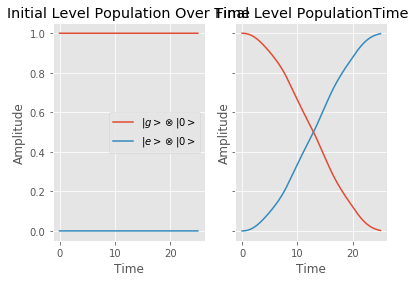

In [9]:
results = grape_pulse.optimize(graph_prob=True)

We get back a dictionary with all the results we need: optimized drive amplitudes, final fidelity, the Hamiltonians (which are allready known if you wrote this script, but usefull if you want to save it to a file), the Hilbert space dimensions and some comments you can add. The dictionary has the form:
* **"pulses"**: *ndarray* of shape (number of drive amplitudes$\ \times\ $number of time steps)
* **"fidelity"**: *float* of the final fidelity
* **"Hamiltonians"**:
    * **"constant"**: *ndarray* matrix of the constant hamiltonian
    * **"drives"**: *list of ndarray* matrices of the drive hamiltonians
* **"dimensions"**: *ndarray* of list of original hilbert space dimensions
* **"comments"**: comments you can add (again, only useful when you save as a file and want to understand what these results mean

### 👉 Graphing the results 📈

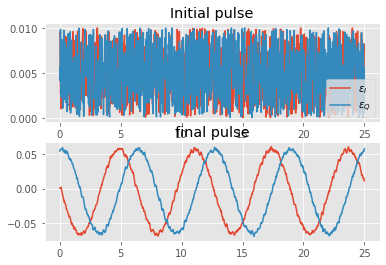

In [10]:
pulses = results["pulses"]

fig, axes = plt.subplots(2)
# --- Initial ---
axes[0].set_title("Initial pulse")
axes[0].plot(times, e_I)
axes[0].plot(times, e_Q)
axes[0].legend([r'$\epsilon_I$', r'$\epsilon_Q$'])
# --- Final ---
axes[1].set_title("final pulse")
axes[1].plot(times,  pulses[0])
axes[1].plot(times,  pulses[1])

Why isn't this smooth like we expect from theory? You can find the answer to this in the manusctpt, but to fix this, we need to add **constraints**.

### Checking the final fidelity
One last thing we need to check is that the final fidelity is actually close to $1$, let's check that now

In [11]:
print("A fidelity of", results["fidelity"], "was achieved by the optimization")

A fidelity of 0.9971545398400421 was achieved by the optimization
